## Imports

In [1]:
from datetime import datetime, timedelta
import logging
import pandas as pd
import numpy as np

from prometheus_api_client import MetricRangeDataFrame, PrometheusConnect

import sklearn
from sklearn.datasets import fetch_california_housing

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor


from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.utils import Bunch

import matplotlib.pyplot as plt

## Constants

In [2]:
PROM_URL_THINKPAD = "http://localhost:9090"
PROM_URL_BEAKER = "http://localhost:9091"
PROM_URL = PROM_URL_BEAKER
RATE_INTERVAL = "20s"

METRIC_BPF_CPU_TIME = "kepler_process_bpf_cpu_time_ms_total"
QUERY_BPF_CPU_TIME = "sum(rate(kepler_process_bpf_cpu_time_ms_total{}[{}]))"
COLUMNS_COMMAND_PID = ['command', 'pid']

METRIC_CPU_INSTRUCTIONS = "kepler_process_cpu_instructions_total"
QUERY_CPU_INSTRUCTIONS = "sum(rate(kepler_process_cpu_instructions_total{}[{}]))"

METRIC_CPU_CYCLES = "kepler_process_cpu_cycles_total"
QUERY_CPU_CYCLES = "sum(rate(kepler_process_cpu_cycles_total{}[{}]))"

METRIC_PKG_JOULES_TOTAL = "kepler_node_package_joules_total"
QUERY_KEPLER_PKG_JOULES_TOTAL = "sum(rate(kepler_node_package_joules_total{}[{}]))"

METRIC_VM_PKG_JOULES_TOTAL = "kepler_vm_package_joules_total"
QUERY_KEPLER_VM_PKG_JOULES_TOTAL = "sum(rate(kepler_vm_package_joules_total{}[{}]))"

METRIC_VM_BPF_CPU_TIME_TOTAL = "kepler_vm_bpf_cpu_time_ms_total"
QUERY_KEPLER_VM_BPF_CPU_TIME_TOTAL = "sum(rate(kepler_vm_bpf_cpu_time_ms_total{}[{}]))"

METRIC_VM_CPU_CYCLES_TOTAL = "kepler_vm_cpu_cycles_total"
QUERY_KEPLER_VM_CPU_CYCLES_TOTAL = "sum(rate(kepler_vm_cpu_cycles_total{}[{}]))"

METRIC_VM_CPU_INSTRUCTIONS_TOTAL = "kepler_vm_cpu_instructions_total"
QUERY_KEPLER_VM_CPU_INSTRUCTIONS_TOTAL = "sum(rate(kepler_vm_cpu_instructions_total{}[{}]))"


METRIC_NODE_RAPL_PKG_JOULES_TOTAL = "node_rapl_package_joules_total"
QUERY_NODE_RAPL_PKG_JOULES_TOTAL = "sum(rate(node_rapl_package_joules_total{}[{}]))"
LABEL_RAPL_PATH = "/host/sys/class/powercap/intel-rapl:0"

METRIC_NODE_CPU_SCALING_FREQUENCY_HERTZ = "node_cpu_scaling_frequency_hertz"
QUERY_NODE_CPU_SCALING_FREQUENCY_HERTZ = "sum(node_cpu_scaling_frequency_hertz{})"
LABEL_RAPL_PATH = "/host/sys/class/powercap/intel-rapl:0"

JOB_DEV = {"job":"dev"}
JOB_METAL = {"job":"metal"}
JOB_VM = {"job":"vm"}
JOB_NODE_EXPORTER = {"job":"node-exporter"}
JOB_NODE_EXPORTER_VM = {"job":"node-exporter-vm"}

COMMAND_STRESS = {"command": ".*stress.*"}

METRIC_UP = "up"

## Set log level

In [3]:
logging.basicConfig(level=logging.ERROR)

In [4]:
def train_lr(data):
    X = data.drop('PRICE', axis=1)
    y = data['PRICE']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print("Coefficients:")
    for feature, coef in zip(X.columns, model.coef_):
        print(f"{feature}: {coef}")
    return model

In [5]:
def test_california_housing():
    california: Bunch = fetch_california_housing()
    data: pd.DataFrame = pd.DataFrame(california.data, columns=california.feature_names)
    data['PRICE'] = california.target
    print(data.head())
    data.plot()
    plt.show()
    model = train_lr(data)
    return model

In [6]:
def fetch_prometheus_data(start_time, end_time, query, rename_value_column, columns=[], label_config: dict = None):
    try:
        prom = PrometheusConnect(url=PROM_URL, disable_ssl=True)
        if label_config:
            label_list = [str(key + "=~" + "'" + label_config[key] + "'") for key in label_config]
            labels = "{" + ",".join(label_list) + "}"
        else:
            labels = ""

        if "rate(" in query:
            query = query.format(labels, RATE_INTERVAL)
        else:
            query = query.format(labels)

        metric_data = prom.custom_query_range(query=query, start_time=start_time, end_time=end_time, step="1s")
        if not metric_data:
            raise ValueError(f"No data found for metric: {query}")
        #print(metric_data)
        metric_df = MetricRangeDataFrame(data=metric_data, columns=(columns + ['timestamp', 'value']), ts_as_datetime=False)
        metric_df.index = metric_df.index.astype('int64')
        metric_df.rename(columns={'value': rename_value_column}, inplace=True)
        metric_df = metric_df.sort_values(by='timestamp')
        return metric_df
    except Exception as e:
        import traceback
        print(f"An error occurred: {e}")
        traceback.print_exc()
        return pd.DataFrame()

In [7]:
def printDF(df: pd.DataFrame):
    df_name = df.attrs['name']
    print(f"{df_name} shape: {df.shape}, Columns: {df.columns}, Index={df.index}")
    print(df)

## Start and end time

In [8]:
duration_5_min = 1000 * 60 * 5
duration_10_min = 1000 * 60 * 10
duration_20_min = 1000 * 60 * 20
duration_30_min = 1000 * 60 * 30
duration_45_min = 1000 * 60 * 45
duration_1_hour = 1000 * 60 * 60
duration_2_hour = duration_1_hour * 2



#end_time = datetime.now()
end_time = datetime.fromtimestamp(1728374796)


duration = duration_1_hour

start_time = end_time - timedelta(milliseconds=duration)
#start_time = 1728371212
#start_time = datetime.fromtimestamp(1727687000)


## Query prometheus and get the following data frames
 - `bpf_cpu_time_df`: bpf cpu time for all processes, from kepler
 - `rapl_pkg_joules_df` : rapl power from Node Exporter
 - `kepler_pkg_joules_df` : kepler process package joules
 - `cpu_inst_df` : cpu instructions for all processes, from kepler

In [9]:
bpf_cpu_time_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_BPF_CPU_TIME,
    rename_value_column='bpf_cpu_time',
    label_config=JOB_METAL,
    #columns=COLUMNS_COMMAND_PID
    )
bpf_cpu_time_df.attrs = {"name": "bpf_cpu_time_df"}
#printDF(bpf_cpu_time_df)

In [10]:
metal_vm_bpf_cpu_time_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_KEPLER_VM_BPF_CPU_TIME_TOTAL,
    rename_value_column='metal_vm_bpf_cpu_time',
    label_config=JOB_METAL,
    #columns=COLUMNS_COMMAND_PID
    )
metal_vm_bpf_cpu_time_df.attrs = {"name": "metal_vm_bpf_cpu_time_df"}
#printDF(metal_vm_bpf_cpu_time_df)

In [11]:
vm_bpf_cpu_time_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_BPF_CPU_TIME,
    rename_value_column='vm_bpf_cpu_time',
    label_config=JOB_VM,
    #columns=COLUMNS_COMMAND_PID
    )
vm_bpf_cpu_time_df.attrs = {"name": "vm_bpf_cpu_time_df"}
#printDF(vm_bpf_cpu_time_df)

In [12]:
rapl_pkg_joules_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_NODE_RAPL_PKG_JOULES_TOTAL,
    rename_value_column='rapl_pkg_joules',
    label_config=JOB_NODE_EXPORTER)
rapl_pkg_joules_df.attrs = {"name": "rapl_pkg_joules_df"}
#printDF(rapl_pkg_joules_df)

In [13]:
kepler_node_pkg_joules_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_KEPLER_PKG_JOULES_TOTAL,
    rename_value_column='kepler_node_pkg_joules',
    label_config=JOB_METAL,
    columns=COLUMNS_COMMAND_PID)
kepler_node_pkg_joules_df.attrs = {"name": "kepler_node_pkg_joules_df"}
#printDF(kepler_node_pkg_joules_df)

In [14]:
kepler_vm_pkg_joules_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_KEPLER_VM_PKG_JOULES_TOTAL,
    rename_value_column='kepler_vm_pkg_joules',
    label_config=JOB_METAL,
    columns=COLUMNS_COMMAND_PID)
kepler_vm_pkg_joules_df.attrs = {"name": "kepler_vm_pkg_joules_df"}
#printDF(kepler_pkg_joules_df)

In [15]:
cpu_inst_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_CPU_INSTRUCTIONS,
    rename_value_column='cpu_instructions',
    label_config=JOB_METAL,
    columns=COLUMNS_COMMAND_PID)
cpu_inst_df.attrs = {"name": "cpu_inst_df"}
#printDF(cpu_inst_df)

In [16]:
cpu_cycles_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_CPU_CYCLES,
    rename_value_column='cpu_cycles',
    label_config=JOB_METAL,
    columns=COLUMNS_COMMAND_PID)
cpu_cycles_df.attrs = {"name": "cpu_cycles_df"}    
#printDF(cpu_cycles_df)

In [17]:
cpu_scaling_freq_df = fetch_prometheus_data(
    start_time=start_time,
    end_time=end_time,
    query=QUERY_NODE_CPU_SCALING_FREQUENCY_HERTZ,
    rename_value_column='cpu_scaling_freq',
    label_config=JOB_NODE_EXPORTER,
    columns=COLUMNS_COMMAND_PID)
cpu_scaling_freq_df.attrs = {"name": "cpu_scaling_freq_df"}    
#printDF(cpu_scaling_freq_df)

An error occurred: No data found for metric: sum(node_cpu_scaling_frequency_hertz{job=~'node-exporter'})


Traceback (most recent call last):
  File "/tmp/ipykernel_1421238/1565805373.py", line 17, in fetch_prometheus_data
    raise ValueError(f"No data found for metric: {query}")
ValueError: No data found for metric: sum(node_cpu_scaling_frequency_hertz{job=~'node-exporter'})


## Scale by num of CPUs

In [18]:
num_cpus = 16

#bpf_cpu_time_df['bpf_cpu_time'] = bpf_cpu_time_df['bpf_cpu_time'] / num_cpus
#cpu_inst_df['cpu_instructions'] = cpu_inst_df['cpu_instructions'] / num_cpus
#cpu_cycles_df['cpu_cycles'] = cpu_cycles_df['cpu_cycles'] / num_cpus

#rapl_pkg_joules_df['rapl_pkg_joules'] = rapl_pkg_joules_df['rapl_pkg_joules'] / num_cpus


## Sample values

In [19]:
vm_bpf_cpu_time_df.sample

<bound method NDFrame.sample of             vm_bpf_cpu_time
timestamp                  
1728371196      1008.533333
1728371197      1008.533333
1728371198      1012.400000
1728371199      1012.400000
1728371200      1012.400000
...                     ...
1728374792      1005.400000
1728374793      1005.800000
1728374794      1005.800000
1728374795      1005.800000
1728374796      1005.800000

[3601 rows x 1 columns]>

In [20]:
bpf_cpu_time_df.sample

<bound method NDFrame.sample of             bpf_cpu_time
timestamp               
1728371196   1025.733333
1728371197   1024.200000
1728371198   1024.200000
1728371199   1024.200000
1728371200   1024.200000
...                  ...
1728374792   1030.266667
1728374793   1030.266667
1728374794   1030.266667
1728374795   1030.266667
1728374796   1030.266667

[3601 rows x 1 columns]>

In [21]:
rapl_pkg_joules_df.head()

,rapl_pkg_joules
timestamp,
1728371196,26.569121
1728371197,26.533147
1728371198,26.533147
1728371199,26.533147
1728371200,26.533147


## Plot 'em

<Axes: xlabel='timestamp'>

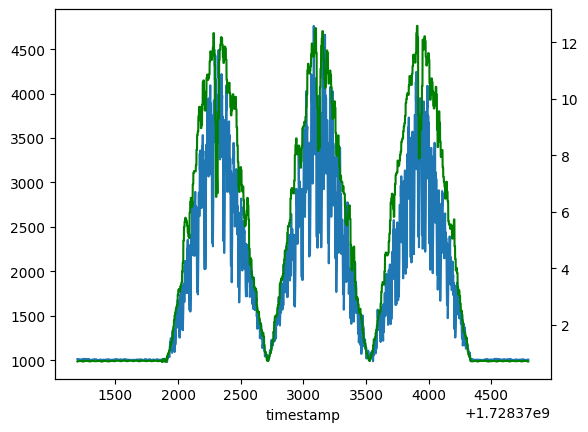

In [22]:
ax = vm_bpf_cpu_time_df['vm_bpf_cpu_time'].plot(label='vm_bpf_cpu_time')
ax2 = ax.twinx()
#rapl_pkg_joules_df.plot(ax = ax2, color='orange', label='rapl_pkg_joules')
#kepler_pkg_joules_df.plot(ax = ax2, color='green', label='kepler_pkg_joules')
kepler_vm_pkg_joules_df['kepler_vm_pkg_joules'].plot(ax = ax2, color='green', label='kepler_vm_pkg_joules')

<Axes: xlabel='timestamp'>

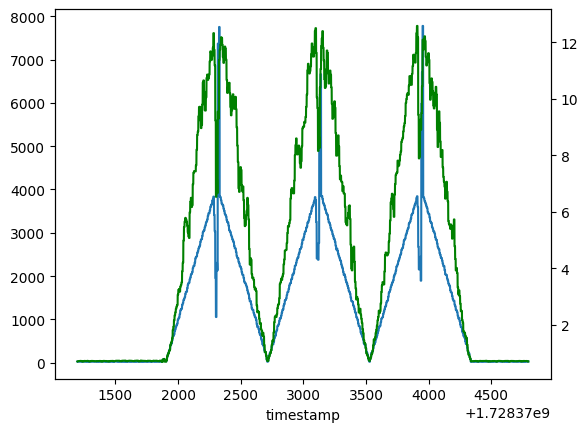

In [23]:
ax = metal_vm_bpf_cpu_time_df['metal_vm_bpf_cpu_time'].plot(label='metal_vm_bpf_cpu_time')
#ax = vm_bpf_cpu_time_df['vm_bpf_cpu_time'].plot(label='vm_bpf_cpu_time')

ax2 = ax.twinx()
#rapl_pkg_joules_df.plot(ax = ax2, color='orange', label='rapl_pkg_joules')
#kepler_pkg_joules_df.plot(ax = ax2, color='green', label='kepler_pkg_joules')
kepler_vm_pkg_joules_df['kepler_vm_pkg_joules'].plot(ax = ax2, color='green', label='kepler_vm_pkg_joules')

In [24]:
#cpu_inst_df.plot()
#cpu_cycles_df.plot()
#cpu_scaling_freq_df
#plt.show()

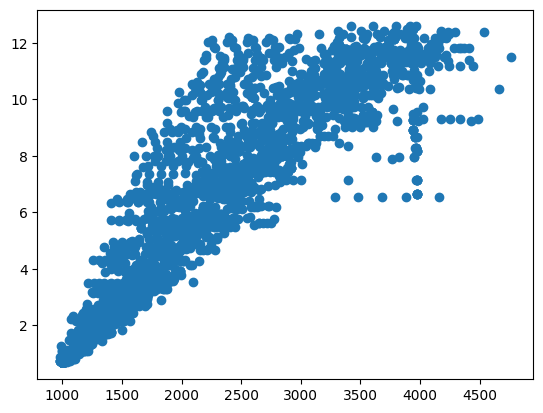

In [25]:
#plt.scatter(x = bpf_cpu_time_df['bpf_cpu_time'], y = rapl_pkg_joules_df['rapl_pkg_joules'])
plt.scatter(x = vm_bpf_cpu_time_df['vm_bpf_cpu_time'], y = kepler_vm_pkg_joules_df['kepler_vm_pkg_joules'])

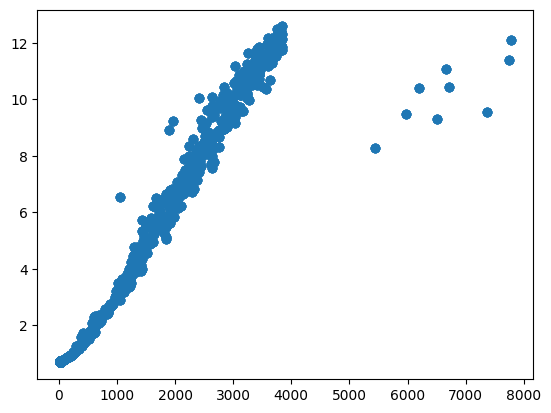

In [26]:
#plt.scatter(x = bpf_cpu_time_df['bpf_cpu_time'], y = rapl_pkg_joules_df['rapl_pkg_joules'])
plt.scatter(x = metal_vm_bpf_cpu_time_df['metal_vm_bpf_cpu_time'], y = kepler_vm_pkg_joules_df['kepler_vm_pkg_joules'])

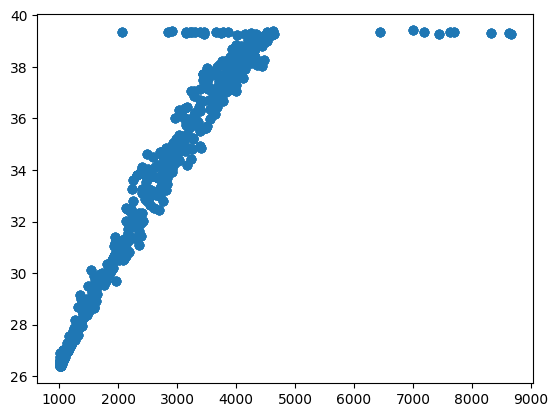

In [27]:
plt.scatter(x = bpf_cpu_time_df['bpf_cpu_time'], y = rapl_pkg_joules_df['rapl_pkg_joules'])

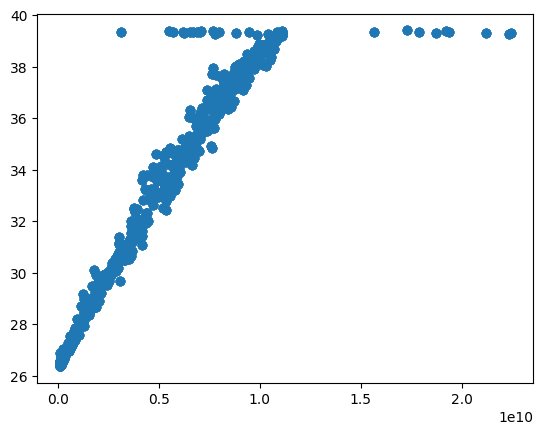

In [28]:
plt.scatter(x = cpu_cycles_df['cpu_cycles'], y = rapl_pkg_joules_df['rapl_pkg_joules'])

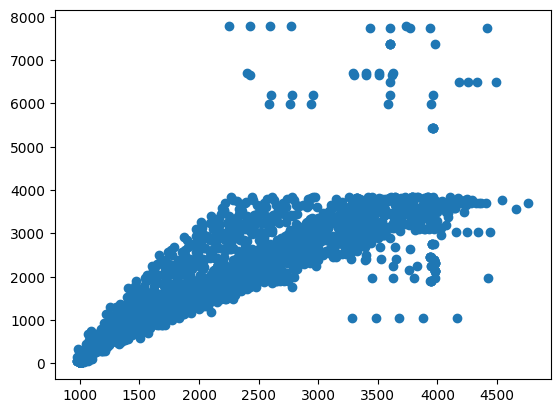

In [29]:
plt.scatter(x = vm_bpf_cpu_time_df['vm_bpf_cpu_time'], y = metal_vm_bpf_cpu_time_df['metal_vm_bpf_cpu_time'])

In [30]:
#corr = pd.DataFrame(vm_bpf_cpu_time_df['vm_bpf_cpu_time']).corrwith(pd.DataFrame(metal_vm_bpf_cpu_time_df['metal_vm_bpf_cpu_time']))   
#print(corr)
print(vm_bpf_cpu_time_df.sample)
print(metal_vm_bpf_cpu_time_df.sample)
df = pd.DataFrame(vm_bpf_cpu_time_df['vm_bpf_cpu_time'], index=metal_vm_bpf_cpu_time_df.index, columns=['vm_bpf_cpu_time'])
corr = df.corrwith(metal_vm_bpf_cpu_time_df['metal_vm_bpf_cpu_time'])   
corr_value = corr['vm_bpf_cpu_time']
print(f"Correlation        : {corr_value:4f}")

<bound method NDFrame.sample of             vm_bpf_cpu_time
timestamp                  
1728371196      1008.533333
1728371197      1008.533333
1728371198      1012.400000
1728371199      1012.400000
1728371200      1012.400000
...                     ...
1728374792      1005.400000
1728374793      1005.800000
1728374794      1005.800000
1728374795      1005.800000
1728374796      1005.800000

[3601 rows x 1 columns]>
<bound method NDFrame.sample of             metal_vm_bpf_cpu_time
timestamp                        
1728371196              30.066667
1728371197              30.066667
1728371198              30.066667
1728371199              30.066667
1728371200              30.066667
...                           ...
1728374792              31.666667
1728374793              31.666667
1728374794              31.666667
1728374795              31.666667
1728374796              31.666667

[3601 rows x 1 columns]>
Correlation        : 0.907759


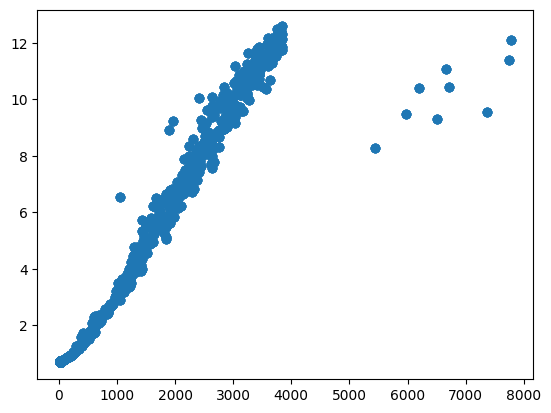

In [31]:
plt.scatter(x = metal_vm_bpf_cpu_time_df['metal_vm_bpf_cpu_time'], y = kepler_vm_pkg_joules_df['kepler_vm_pkg_joules'])

In [32]:
print(vm_bpf_cpu_time_df['vm_bpf_cpu_time'].sample)

<bound method NDFrame.sample of timestamp
1728371196    1008.533333
1728371197    1008.533333
1728371198    1012.400000
1728371199    1012.400000
1728371200    1012.400000
                 ...     
1728374792    1005.400000
1728374793    1005.800000
1728374794    1005.800000
1728374795    1005.800000
1728374796    1005.800000
Name: vm_bpf_cpu_time, Length: 3601, dtype: float64>


In [33]:
print(metal_vm_bpf_cpu_time_df['metal_vm_bpf_cpu_time'].sample)

<bound method NDFrame.sample of timestamp
1728371196    30.066667
1728371197    30.066667
1728371198    30.066667
1728371199    30.066667
1728371200    30.066667
                ...    
1728374792    31.666667
1728374793    31.666667
1728374794    31.666667
1728374795    31.666667
1728374796    31.666667
Name: metal_vm_bpf_cpu_time, Length: 3601, dtype: float64>


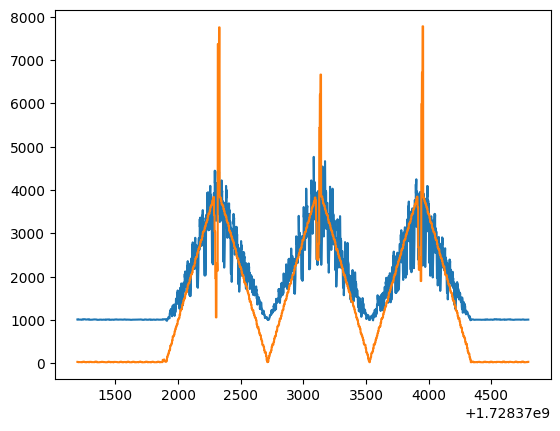

In [34]:
plt.plot(vm_bpf_cpu_time_df['vm_bpf_cpu_time'])
plt.plot(metal_vm_bpf_cpu_time_df['metal_vm_bpf_cpu_time'])
plt.show()

# Prepare input data for training

In [35]:
#X = pd.DataFrame(bpf_cpu_time_df['bpf_cpu_time'], cpu_inst_df['cpu_instructions'])
#X = bpf_cpu_time_df.drop(['command', 'pid', 'bpf_cpu_time_ratio'], axis =1)
X = vm_bpf_cpu_time_df
#X['cpu_instructions'] = cpu_inst_df['cpu_instructions']
#X['cpu_cycles'] = cpu_cycles_df['cpu_cycles']
#X['cpu_scaling_freq'] = cpu_scaling_freq_df['cpu_scaling_freq']
y = pd.DataFrame(kepler_vm_pkg_joules_df['kepler_vm_pkg_joules'])

In [36]:
X.sample

<bound method NDFrame.sample of             vm_bpf_cpu_time
timestamp                  
1728371196      1008.533333
1728371197      1008.533333
1728371198      1012.400000
1728371199      1012.400000
1728371200      1012.400000
...                     ...
1728374792      1005.400000
1728374793      1005.800000
1728374794      1005.800000
1728374795      1005.800000
1728374796      1005.800000

[3601 rows x 1 columns]>

In [37]:
X.columns

Index(['vm_bpf_cpu_time'], dtype='object')

In [38]:
X.shape

(3601, 1)

In [39]:
y.sample

<bound method NDFrame.sample of             kepler_vm_pkg_joules
timestamp                       
1728371196                0.6984
1728371197                0.7056
1728371198                0.7056
1728371199                0.7056
1728371200                0.7056
...                          ...
1728374792                0.6972
1728374793                0.6972
1728374794                0.6972
1728374795                0.6972
1728374796                0.6972

[3601 rows x 1 columns]>

# Split into training and test data

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.columns)
X_train.sample

Index(['vm_bpf_cpu_time'], dtype='object')


<bound method NDFrame.sample of             vm_bpf_cpu_time
timestamp                  
1728373267      2237.620383
1728371484      1001.000000
1728373027      3389.861125
1728373580      1241.894400
1728373174      4080.395225
...                     ...
1728372326      4334.005850
1728372490      1846.214808
1728372056      2070.978867
1728374703      1005.733333
1728374370      1001.400000

[2880 rows x 1 columns]>

# Train Models and test

## Linear Regression

In [41]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")
print("Coefficients:")
for feature, coef in zip(X.columns, lr_model.coef_):
    print(f"{feature}: {coef}")

Mean Squared Error: 2.1512281109147744
R^2 Score: 0.8676015608944905
MAPE: 35.93232149441225
Coefficients:
vm_bpf_cpu_time: [0.0039669]


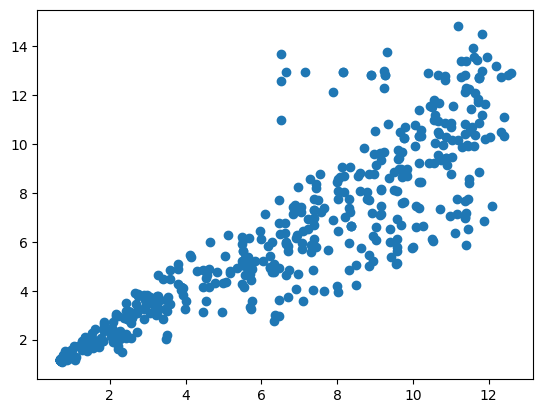

In [42]:
plt.scatter(x = y_test, y = y_pred)

## Polynomial Regression

In [43]:
poly = PolynomialFeatures(degree=2)
pr_model = make_pipeline(poly, LinearRegression())
pr_model.fit(X_train, y_train)

y_pred = pr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100


print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")

#print(model)
#print("Coefficients:")
#for feature, coef in zip(X.columns, model.coef_):
#    print(f"{feature}: {coef}")


Mean Squared Error: 1.3040794064485648
R^2 Score: 0.9197397630649177
MAPE: 16.737750624965813


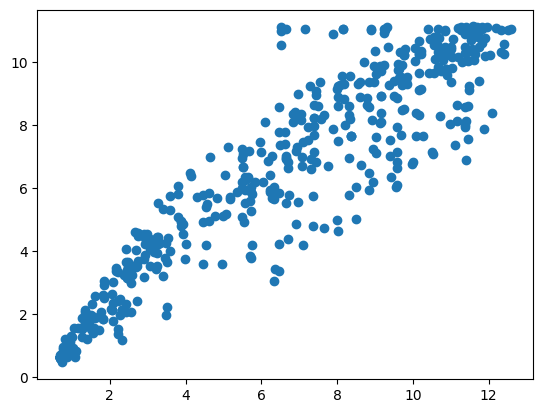

In [44]:
plt.scatter(x = y_test, y = y_pred)

##  Logarithmic Transformation

In [45]:
# Apply log transformation to the target variable
X_train_log = np.log(X_train)

# Fit a Linear Regression model
lt_model = LinearRegression()
lt_model.fit(X_train_log, y_train)

# Predict and reverse log transformation
X_test_log = np.log(X_test)
y_pred = lt_model.predict(X_test_log)
#y_pred_log = lt_model.predict(X_test)
#y_pred = np.exp(y_pred_log)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100


print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")




Mean Squared Error: 1.4260718290519452
R^2 Score: 0.9122316767520631
MAPE: 19.193213969620768


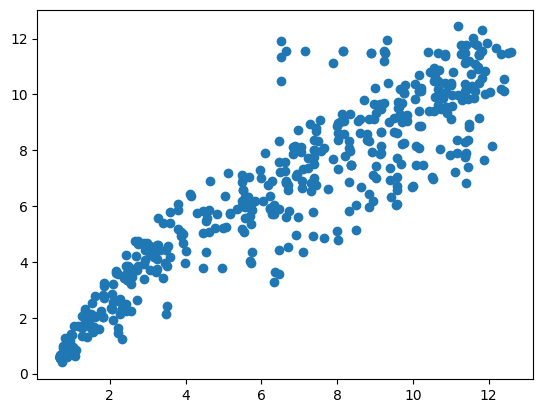

In [46]:
plt.scatter(x = y_test, y = y_pred)

## Decision Trees

In [47]:
dt_model = DecisionTreeRegressor(max_depth=5)  # Tune depth as necessary
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100


print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")


Mean Squared Error: 1.3133418062048035
R^2 Score: 0.919169703914112
MAPE: 11.707497910398285


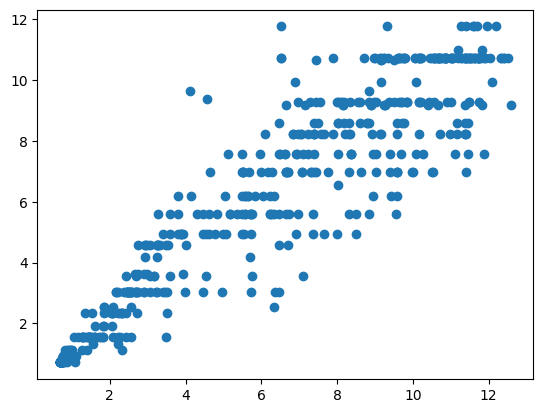

In [48]:
plt.scatter(x = y_test, y = y_pred)

## Random Forests

In [49]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100


print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")


/home/vimalkum/src/powermon/kepler-experimental/vimal/venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 1.666776632332332
R^2 Score: 0.8974173759915686
MAPE: 12.087080591037319


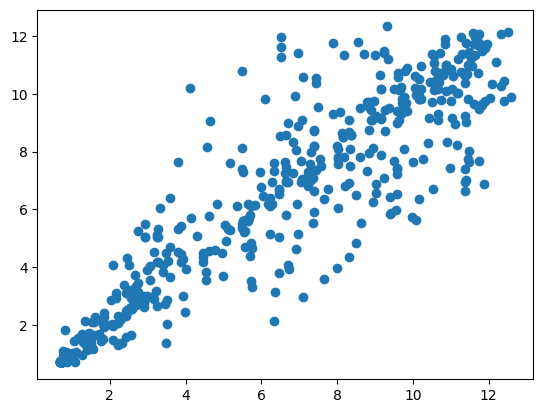

In [50]:
plt.scatter(x = y_test, y = y_pred)

##  Gradient Boosting (XGBoost)

In [51]:
gb_model = XGBRegressor()
gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100


print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")


Mean Squared Error: 1.3072004454743644
R^2 Score: 0.9195476770401001
MAPE: 11.843249074042122


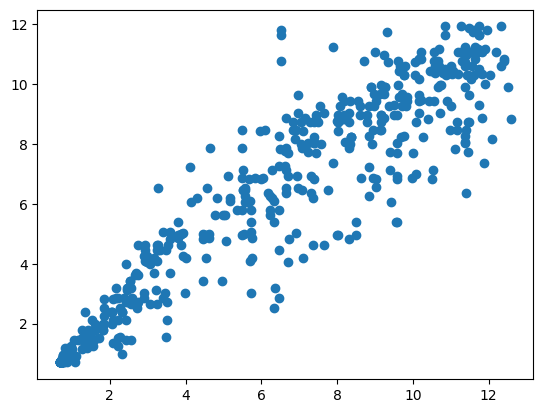

In [52]:
plt.scatter(x = y_test, y = y_pred)

## Support Vector Regression (SVR)

In [53]:
svr_model = SVR(kernel='rbf')  # Try 'poly' for polynomial kernel
svr_model.fit(X_train, y_train)

y_pred = svr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100


print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")


Mean Squared Error: 1.43776833087642
R^2 Score: 0.911511809539145
MAPE: 14.346774420350785


/home/vimalkum/src/powermon/kepler-experimental/vimal/venv/lib64/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


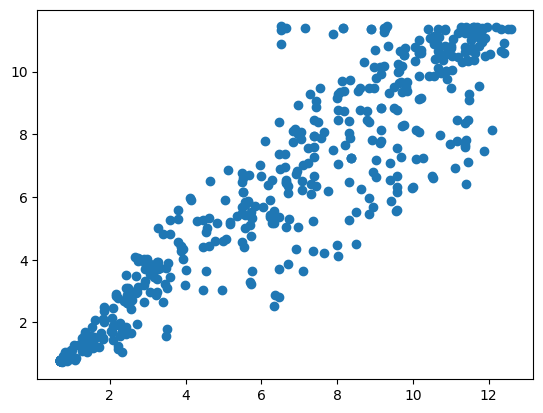

In [54]:
plt.scatter(x = y_test, y = y_pred)

# Model Validation

## Set validation start and end time

In [55]:
validation_end_time = datetime.now()
#end_time = datetime.fromtimestamp(1727088375)

validation_duration = duration_30_min

validation_start_time = validation_end_time - timedelta(milliseconds=validation_duration)

In [56]:
print(f"start: {validation_start_time}")
print(f"end  : {validation_end_time}")

start: 2024-10-09 10:56:37.483396
end  : 2024-10-09 11:26:37.483396


## Validation on vm bpf cpu time

### Fetch new data

In [57]:
vm_bpf_cpu_time_df = fetch_prometheus_data(
    start_time=validation_start_time,
    end_time=validation_end_time,
    query=QUERY_BPF_CPU_TIME,
    rename_value_column='vm_bpf_cpu_time',
    label_config=JOB_VM,    
    #columns=COLUMNS_COMMAND_PID
    )
vm_bpf_cpu_time_df.attrs = {"name": "vm_bpf_cpu_time_df"}
#printDF(vm_bpf_cpu_time_df)

In [58]:
rapl_pkg_joules_df = fetch_prometheus_data(
    start_time=validation_start_time,
    end_time=validation_end_time,
    query=QUERY_NODE_RAPL_PKG_JOULES_TOTAL,
    rename_value_column='rapl_pkg_joules',
    label_config=JOB_NODE_EXPORTER|{"path": LABEL_RAPL_PATH})
rapl_pkg_joules_df.attrs = {"name": "rapl_pkg_joules_df"}
#printDF(rapl_pkg_joules_df)

In [59]:
kepler_pkg_joules_df = fetch_prometheus_data(
    start_time=validation_start_time,
    end_time=validation_end_time,
    query=QUERY_KEPLER_PKG_JOULES_TOTAL,
    rename_value_column='kepler_pkg_joules',
    label_config=JOB_METAL,        
    columns=COLUMNS_COMMAND_PID)
kepler_pkg_joules_df.attrs = {"name": "kepler_pkg_joules_df"}
#printDF(kepler_pkg_joules_df)

In [60]:
vm_pkg_joules_df = fetch_prometheus_data(
    start_time=validation_start_time,
    end_time=validation_end_time,
    query=QUERY_KEPLER_VM_PKG_JOULES_TOTAL,
    rename_value_column='vm_pkg_joules',
    label_config=JOB_METAL)
vm_pkg_joules_df.attrs = {"name": "vm_pkg_joules_df"}
#printDF(vm_pkg_joules_df)

In [61]:
vm_cpu_inst_df = fetch_prometheus_data(
    start_time=validation_start_time,
    end_time=validation_end_time,
    query=QUERY_CPU_INSTRUCTIONS,
    rename_value_column='vm_cpu_instructions',
    label_config=JOB_METAL,        
    columns=COLUMNS_COMMAND_PID)
vm_cpu_inst_df.attrs = {"name": "vm_cpu_inst_df"}
#printDF(vm_cpu_inst_df)

In [62]:
vm_cpu_cycles_df = fetch_prometheus_data(
    start_time=validation_start_time,
    end_time=validation_end_time,
    query=QUERY_CPU_CYCLES,
    rename_value_column='vm_cpu_cycles',
    label_config=JOB_METAL,            
    columns=COLUMNS_COMMAND_PID)
vm_cpu_cycles_df.attrs = {"name": "vm_cpu_cycles_df"}    
#printDF(vm_cpu_cycles_df)

In [63]:
cpu_scaling_freq_df = fetch_prometheus_data(
    start_time=validation_start_time,
    end_time=validation_end_time,
    query=QUERY_NODE_CPU_SCALING_FREQUENCY_HERTZ,
    rename_value_column='cpu_scaling_freq',
    label_config=JOB_NODE_EXPORTER,            
    columns=COLUMNS_COMMAND_PID)
cpu_scaling_freq_df.attrs = {"name": "cpu_scaling_freq_df"}    
#printDF(cpu_scaling_freq_df)

An error occurred: No data found for metric: sum(node_cpu_scaling_frequency_hertz{job=~'node-exporter'})


Traceback (most recent call last):
  File "/tmp/ipykernel_1421238/1565805373.py", line 17, in fetch_prometheus_data
    raise ValueError(f"No data found for metric: {query}")
ValueError: No data found for metric: sum(node_cpu_scaling_frequency_hertz{job=~'node-exporter'})


### Scale by num of cpus

In [64]:
num_vcpus = 2

In [65]:
#vm_bpf_cpu_time_df['bpf_cpu_time'] = vm_bpf_cpu_time_df['bpf_cpu_time'] / num_vcpus
#vm_cpu_inst_df['vm_cpu_instructions'] = vm_cpu_inst_df['vm_cpu_instructions'] / num_vcpus
#vm_cpu_cycles_df['vm_cpu_cycles'] = vm_cpu_cycles_df['vm_cpu_cycles'] / num_vcpus

### prepare vm validation data

In [66]:
X = vm_bpf_cpu_time_df
#X['cpu_instructions'] = vm_cpu_inst_df['vm_cpu_instructions']
#X['cpu_cycles'] = vm_cpu_cycles_df['vm_cpu_cycles']
#X['cpu_scaling_freq'] = cpu_scaling_freq_df['cpu_scaling_freq']

In [67]:
#print(bpf_cpu_time_df.shape)
#bpf_cpu_time_df.sample

In [68]:
X.sample

<bound method NDFrame.sample of             vm_bpf_cpu_time
timestamp                  
1728451597      1005.466667
1728451598      1005.400000
1728451599      1005.400000
1728451600      1005.400000
1728451601      1005.400000
...                     ...
1728453393      1002.133333
1728453394      1002.133333
1728453395      1002.133333
1728453396      1002.133333
1728453397      1002.133333

[1801 rows x 1 columns]>

In [69]:
vm_pkg_joules_df.sample

<bound method NDFrame.sample of             vm_pkg_joules
timestamp                
1728451597         0.7284
1728451598         0.7284
1728451599         0.7284
1728451600         0.7284
1728451601         0.7284
...                   ...
1728453393         0.7228
1728453394         0.7228
1728453395         0.7228
1728453396         0.7228
1728453397         0.7222

[1801 rows x 1 columns]>

### Run Validations

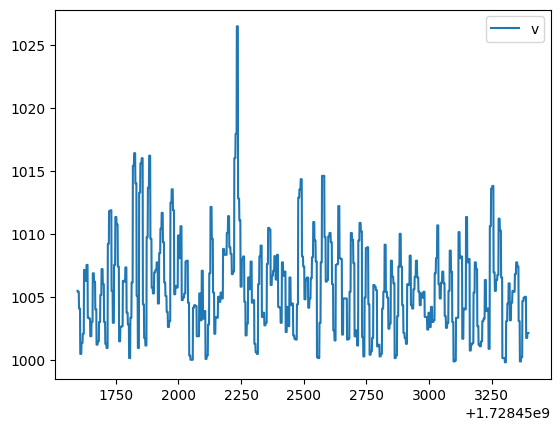

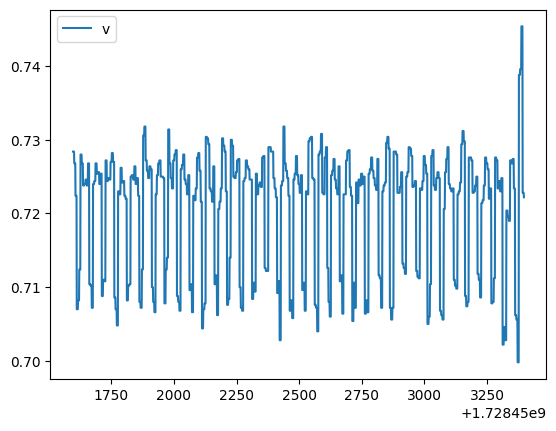

Model : LinearRegression
Mean Squared Error (MSE)         : 0.20075334472189704
Mean Abs percentage Error (MAPE) : 62.163903724504046
R^2 Score                        : -2875.185801526295
Correlation        : 0.242905


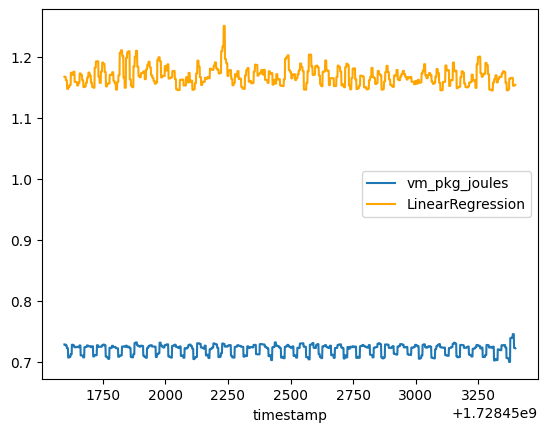

Model : PolynomialRegression
Mean Squared Error (MSE)         : 0.008448734265106526
Mean Abs percentage Error (MAPE) : 12.339413585170963
R^2 Score                        : -120.04470572000173
Correlation        : 0.242969


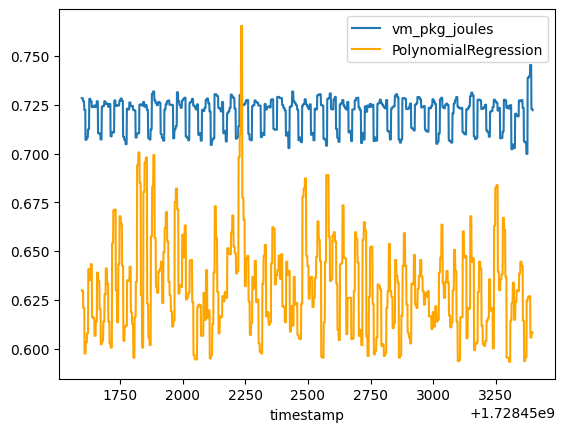

Model : XGBoost
Mean Squared Error (MSE)         : 0.00023051024927177896
Mean Abs percentage Error (MAPE) : 1.449911500525023
R^2 Score                        : -2.3025118808367355
Correlation        : 0.068810


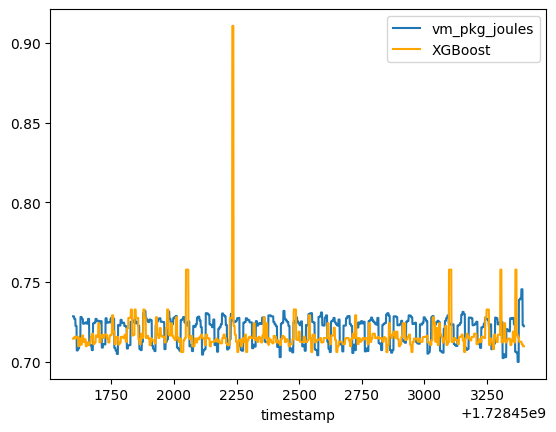

In [70]:
trained_models = {"LinearRegression":lr_model}|{"PolynomialRegression":pr_model}|{"DecisionTree":dt_model}|{"RandomForest":rf_model}|{"XGBoost":gb_model}|{"SVR":svr_model}|{"LogarithmicTransformation":lt_model}
test_models = {"LinearRegression":lr_model}|{"PolynomialRegression":pr_model}|{"XGBoost":gb_model}


plt.plot(X['vm_bpf_cpu_time'])
plt.legend('vm_bpf_cpu_time')
plt.show()
plt.plot(vm_pkg_joules_df['vm_pkg_joules'])
plt.legend('vm_pkg_joules')
plt.show()


for model_name, model in test_models.items():
    ax = vm_pkg_joules_df['vm_pkg_joules'].plot(legend="vm_pkg_joules")
    #ax2 = ax.twinx()
    
    x_test = X
    print(f"Model : {model_name}")
    if model_name == "LogarithmicTransformation":
        x_test = np.log(X)
    y_pred = model.predict(x_test)
    #y_pred = y_pred * num_vcpus
    mse = mean_squared_error(vm_pkg_joules_df['vm_pkg_joules'], y_pred)
    r2 = r2_score(vm_pkg_joules_df['vm_pkg_joules'], y_pred)
    mape = mean_absolute_percentage_error(vm_pkg_joules_df['vm_pkg_joules'], y_pred) * 100

    
    
    print(f"Mean Squared Error (MSE)         : {mse}")
    print(f"Mean Abs percentage Error (MAPE) : {mape}")    
    print(f"R^2 Score                        : {r2}")    
    df = pd.DataFrame(y_pred, index=vm_pkg_joules_df.index, columns=[model_name])
    corr = df.corrwith(vm_pkg_joules_df['vm_pkg_joules'])   
    corr_value = corr[model_name]
    print(f"Correlation        : {corr_value:4f}")
    
    df.plot(ax = ax, color="orange", legend=model_name)


    plt.legend()
    plt.show()

Model : LinearRegression
Mean Squared Error (MSE)         : 643.6467600770809
Mean Abs percentage Error (MAPE) : 95.59763442537829
R^2 Score                        : -125115.23089802111
Correlation        : 0.134880


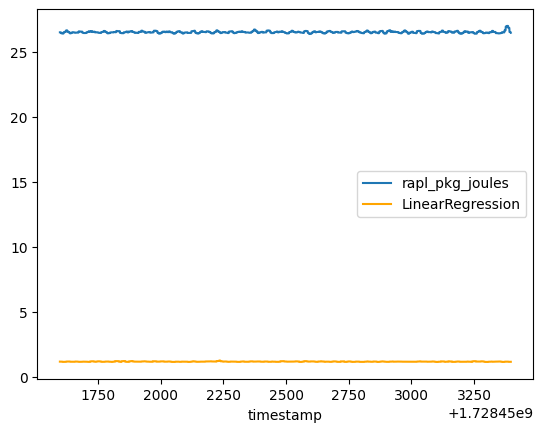

Model : PolynomialRegression
Mean Squared Error (MSE)         : 671.1574862660349
Mean Abs percentage Error (MAPE) : 97.61930322779281
R^2 Score                        : -130462.94424566103
Correlation        : 0.134921


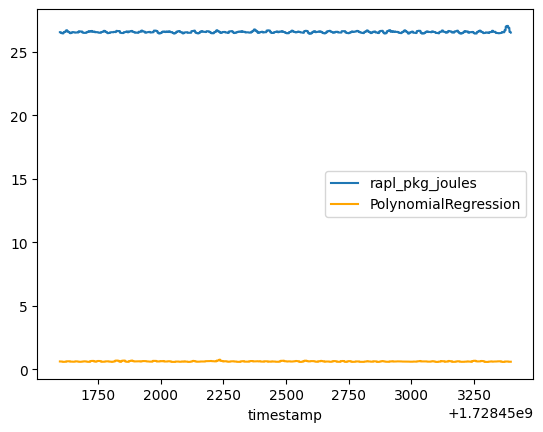

Model : XGBoost
Mean Squared Error (MSE)         : 666.7779686322438
Mean Abs percentage Error (MAPE) : 97.30023042579205
R^2 Score                        : -129611.62520938445
Correlation        : -0.046931


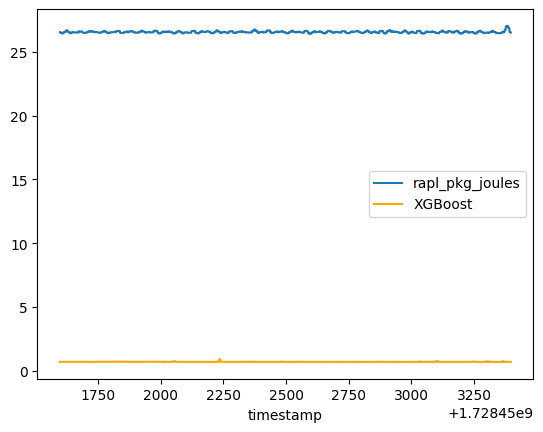

In [71]:
trained_models = {"LinearRegression":lr_model}|{"PolynomialRegression":pr_model}|{"DecisionTree":dt_model}|{"RandomForest":rf_model}|{"XGBoost":gb_model}|{"SVR":svr_model}|{"LogarithmicTransformation":lt_model}
test_models = {"LinearRegression":lr_model}|{"PolynomialRegression":pr_model}|{"XGBoost":gb_model}

for model_name, model in test_models.items():
    ax = rapl_pkg_joules_df['rapl_pkg_joules'].plot(legend="rapl_pkg_joules")
    #ax2 = ax.twinx()
    
    x_test = X
    print(f"Model : {model_name}")
    if model_name == "LogarithmicTransformation":
        x_test = np.log(X)
    y_pred = model.predict(x_test)
    #y_pred = y_pred * num_vcpus
    mse = mean_squared_error(rapl_pkg_joules_df['rapl_pkg_joules'], y_pred)
    r2 = r2_score(rapl_pkg_joules_df['rapl_pkg_joules'], y_pred)
    mape = mean_absolute_percentage_error(rapl_pkg_joules_df['rapl_pkg_joules'], y_pred) * 100

    
    
    print(f"Mean Squared Error (MSE)         : {mse}")
    print(f"Mean Abs percentage Error (MAPE) : {mape}")    
    print(f"R^2 Score                        : {r2}")    
    df = pd.DataFrame(y_pred, index=rapl_pkg_joules_df.index, columns=[model_name])
    corr = df.corrwith(rapl_pkg_joules_df['rapl_pkg_joules'])   
    corr_value = corr[model_name]
    print(f"Correlation        : {corr_value:4f}")
    
    df.plot(ax = ax, color="orange", legend=model_name)


    plt.legend()
    plt.show()